### Imports

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

### Data preparation

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])


train_data = datasets.MNIST(root="../docs/exercises/vae/data", train=True, transform=transform, download=True)
test_data  = datasets.MNIST(root="../docs/exercises/vae/data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=128, shuffle=False)

### VAE Architecture

Encoder + Reparametrization + Decoder

In [42]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 400),
            nn.ReLU(),
        )

        self.mu = nn.Linear(400, latent_dim)
        self.logvar = nn.Linear(400, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def reparameterization(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparameterization(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

### Loss Function (Reconstruction + KL Divergence)

In [43]:
def loss_function(x_hat, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 28*28), reduction="sum"
    )
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

### Training

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 20
loss_history = []

for epoch in range(epochs):
    total_loss = 0
    model.train()
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()

        x_hat, mu, logvar = model(x)
        loss = loss_function(x_hat, x, mu, logvar)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg = total_loss / len(train_loader.dataset)
    loss_history.append(avg)
    print(f"Epoch {epoch+1}, Loss = {avg:.4f}")


Epoch 1, Loss = 189.7536
Epoch 2, Loss = 167.9521
Epoch 3, Loss = 163.4574
Epoch 4, Loss = 161.2515
Epoch 5, Loss = 159.7482
Epoch 6, Loss = 158.5596
Epoch 7, Loss = 157.6024
Epoch 8, Loss = 156.7124
Epoch 9, Loss = 156.0639
Epoch 10, Loss = 155.3979
Epoch 11, Loss = 154.8181
Epoch 12, Loss = 154.2656
Epoch 13, Loss = 153.7885
Epoch 14, Loss = 153.3318
Epoch 15, Loss = 152.9116
Epoch 16, Loss = 152.5109
Epoch 17, Loss = 152.0768
Epoch 18, Loss = 151.8179
Epoch 19, Loss = 151.4695
Epoch 20, Loss = 151.1283


### Loss Function Visualization

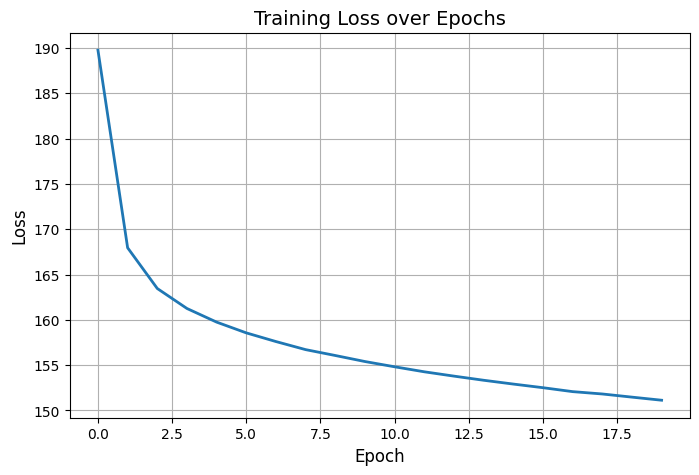

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(loss_history, linewidth=2)
plt.title("Training Loss over Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True)

plt.savefig("../docs/exercises/vae/images/training_loss.png", dpi=300, bbox_inches="tight")
plt.show()

### Reconstruction Visualization

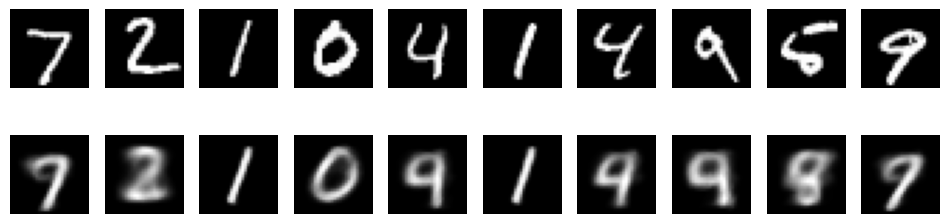

In [ ]:
model.eval()
x, _ = next(iter(test_loader))
x = x.to(device)
with torch.no_grad():
    x_hat, _, _ = model(x)

x_hat = x_hat.cpu().view(-1, 1, 28, 28)

fig, axes = plt.subplots(2, 10, figsize=(12, 3))
for i in range(10):
    axes[0,i].imshow(x[i].cpu().squeeze(), cmap="gray")
    axes[1,i].imshow(x_hat[i].squeeze(), cmap="gray")
    axes[0,i].axis("off")
    axes[1,i].axis("off")
plt.savefig("../docs/exercises/vae/images/reconstructions.png",dpi=300, bbox_inches="tight")
plt.show()

### Latent Space (2D) Visualization

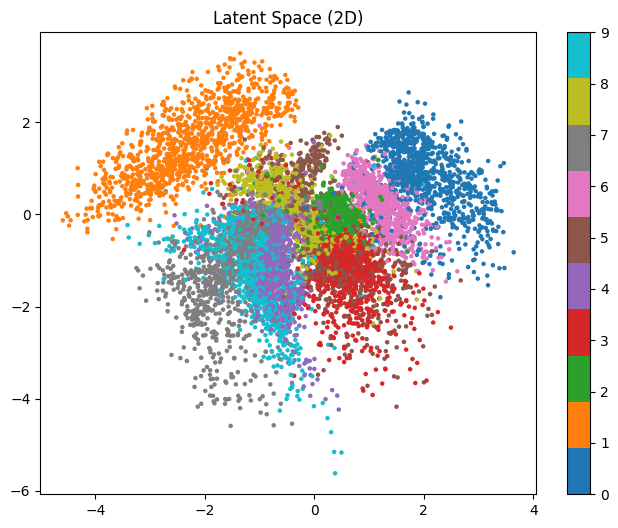

In [ ]:
zs = []
labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        _, mu, _ = model(x)
        zs.append(mu.cpu())
        labels.append(y)

zs = torch.cat(zs)
labels = torch.cat(labels)

plt.figure(figsize=(8,6))
plt.scatter(zs[:,0], zs[:,1], c=labels, cmap="tab10", s=5)
plt.colorbar()
plt.title("Latent Space (2D)")
plt.savefig("../docs/exercises/vae/images/latent_space.png", dpi=300, bbox_inches="tight")
plt.show()

### Generation of New Samples

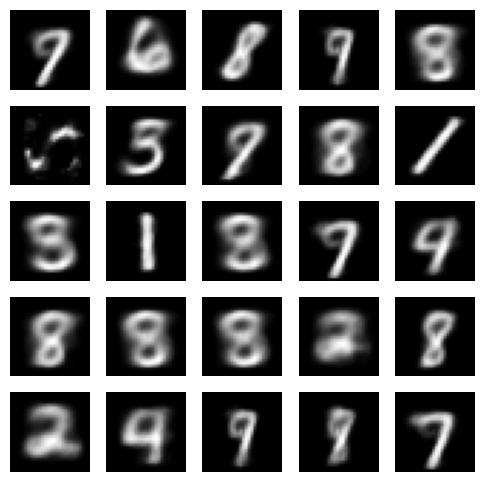

In [ ]:
with torch.no_grad():
    z = torch.randn(25, 2).to(device)
    samples = model.decoder(z).cpu().view(-1, 1, 28, 28)

fig, axes = plt.subplots(5, 5, figsize=(6,6))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].squeeze(), cmap="gray")
    ax.axis("off")
plt.savefig("../docs/exercises/vae/images/generated_samples.png", dpi=300, bbox_inches="tight")
plt.show()